**Imports and workspace setting**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from keras import backend as K
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score
from tensorflow.keras.utils import plot_model

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

%matplotlib inline

Using TensorFlow backend.


/kaggle/input/uci-credit-approval-data-set/UCI_crx.csv


**Loading data**

In [ ]:
dataset = pd.read_csv('../input/uci-credit-approval-data-set/UCI_crx.csv')
dataset.shape

(690, 16)

In [ ]:
dataset.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


**Converting data types to tensor supported data types**

In [ ]:
dataset.dtypes

A1      object
A2      object
A3     float64
A4      object
A5      object
A6      object
A7      object
A8     float64
A9      object
A10     object
A11      int64
A12     object
A13     object
A14     object
A15      int64
A16     object
dtype: object

In [ ]:
for col in ['A1', 'A2','A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13', 'A14', 'A16']:
    dataset[col] = pd.Categorical(dataset[col])
    dataset[col] = dataset[col].cat.codes

In [ ]:
dataset.dtypes

A1        int8
A2       int16
A3     float64
A4        int8
A5        int8
A6        int8
A7        int8
A8     float64
A9        int8
A10       int8
A11      int64
A12       int8
A13       int8
A14      int16
A15      int64
A16       int8
dtype: object

In [ ]:
dataset.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,2,156,0.000,2,1,13,8,1.25,1,1,1,0,0,68,0,0
1,1,328,4.460,2,1,11,4,3.04,1,1,6,0,0,11,560,0
2,1,89,0.500,2,1,11,4,1.50,1,0,0,0,0,96,824,0
3,2,125,1.540,2,1,13,8,3.75,1,1,5,1,0,31,3,0
4,2,43,5.625,2,1,13,8,1.71,1,0,0,0,2,37,0,0


**Normalizing input and output vectors**

Scale and normalize to make the magnitude of the features similar. Most popular methods for neumerical data are Min Max normalization and Standard normalization (z score). This will improve the model performance and convergence.

https://visualstudiomagazine.com/articles/2014/01/01/how-to-standardize-data-for-neural-networks.aspx
https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

In [ ]:
# create scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dataset = pd.DataFrame(scaler.fit_transform(dataset))

dataset.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,0.830435,0.431315,0.169954,0.738647,0.488889,0.476605,0.666023,0.078014,0.523188,0.427536,0.035821,0.457971,0.088406,0.349369,0.010174,0.555072
std,0.254597,0.275613,0.177792,0.159029,0.286709,0.308590,0.288278,0.117422,0.499824,0.495080,0.072581,0.498592,0.278934,0.283716,0.052101,0.497318
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.203438,0.035714,0.666667,0.333333,0.142857,0.444444,0.005789,0.000000,0.000000,0.000000,0.000000,0.000000,0.135294,0.000000,0.000000
50%,1.000000,0.382521,0.098214,0.666667,0.333333,0.428571,0.888889,0.035088,1.000000,0.000000,0.000000,0.000000,0.000000,0.305882,0.000050,1.000000
75%,1.000000,0.647564,0.257411,0.666667,0.333333,0.785714,0.888889,0.092105,1.000000,1.000000,0.044776,1.000000,0.000000,0.564706,0.003955,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
X=dataset.iloc[:,0:15].values   #0:15
Y=dataset.iloc[:,15:16].values

In [ ]:
np.random.seed(42) # Makes the random numbers predictable for easy comparison of models

**Create the model generator function**

Deciding neuron count in each layer and number of hidden layers is difficult and there is no straightforward answer to this.

https://www.heatonresearch.com/2017/06/01/hidden-layers.html

https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

In [ ]:
## Set these parameter before calling create_model function
depthOfNetwork = 3
neuronCountInEachLayer = [16, 9, 1]                                 # try different depth and width
activationFuncEachLayer = ['sigmoid', 'relu', 'sigmoid']            # try values relu, sigmoid, talh
lossFunction = 'binary_crossentropy'                                # try values binary_crossentropy, mean_squared_error
regularizerFunc = tf.keras.regularizers.l2(0)                       # try l1 and l2 with different lambda


def create_model(verbose=False):
  model = tf.keras.models.Sequential()
  
  if verbose:
        print('Network configuration ',neuronCountInEachLayer)
  
  model.add(tf.keras.layers.Dense(neuronCountInEachLayer[0], input_dim=15, activation = activationFuncEachLayer[0], kernel_regularizer=regularizerFunc)) # First Layer
    
  for x in range(1, depthOfNetwork-1):
      model.add(tf.keras.layers.Dense(neuronCountInEachLayer[x], activation = activationFuncEachLayer[x],kernel_regularizer=regularizerFunc))         # Second layer onwards
 
  model.add(tf.keras.layers.Dense(neuronCountInEachLayer[depthOfNetwork-1], activation = activationFuncEachLayer[depthOfNetwork-1]))  # Output layer
    
  model.compile(loss = lossFunction , optimizer = 'adam' , metrics = ['accuracy'] ) 
        
  return model

**Visualizing a single model for ease of understanding**

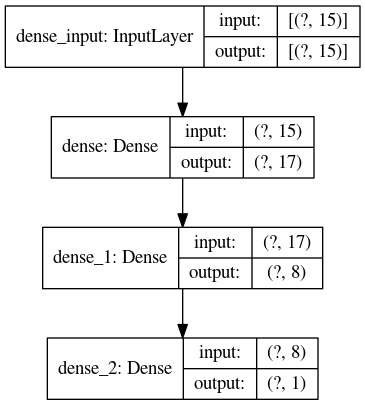

In [ ]:
depthOfNetwork = 3
neuronCountInEachLayer = [17, 8, 1]                                 # try different depth and width
activationFuncEachLayer = ['sigmoid', 'relu', 'sigmoid']            # try values relu, sigmoid, talh
lossFunction = 'binary_crossentropy'                                # try values binary_crossentropy, mean_squared_error
regularizerFunc = tf.keras.regularizers.l2(0)                       # try l1 and l2 with different lambda

model=create_model()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

**Define the evaluator function**

In [ ]:
def evaluateTheModel(verbose=False):
    n_split=5
    f1_scores = []

    for train_index,test_index in StratifiedKFold(n_split).split(X, Y):      # StratifiedKFold, KFold
        x_train,x_test=X[train_index],X[test_index]
        y_train,y_test=Y[train_index],Y[test_index]

        model=create_model(verbose)
        model.fit(x_train, y_train,epochs=100, verbose=0)
        evaluationMetrics = model.evaluate(x_test,y_test, verbose=0)
        
        if verbose:
            print('Model evaluation ',evaluationMetrics)   # This returns metric values for the evaluation

        y_pred = np.where(model.predict(x_test) > 0.5, 1, 0)
        f1 = f1_score(y_test, y_pred , average="macro")

        if verbose:
            print('F1 score is ', f1)
        
        f1_scores.append(f1)
    
    return np.mean(f1_scores)

**Verbose mode of the function to see F1 scores of each fold**

In [ ]:
depthOfNetwork = 2
neuronCountInEachLayer = [2, 1]                                 # try different depth and width
activationFuncEachLayer = ['sigmoid', 'sigmoid']            # try values relu, sigmoid, talh
lossFunction = 'binary_crossentropy'                                # try values binary_crossentropy, mean_squared_error
regularizerFunc = tf.keras.regularizers.l2(0)                       # try l1 and l2 with different lambda

evaluateTheModel(True)

Network configuration  [2, 1]
Model evaluation  [0.586880755939072, 0.68345326]
F1 score is  0.6814583333333334
Network configuration  [2, 1]
Model evaluation  [0.4185366113837674, 0.94244605]
F1 score is  0.9411016949152542
Network configuration  [2, 1]
Model evaluation  [0.48107396778853045, 0.84782606]
F1 score is  0.8360396039603961
Network configuration  [2, 1]
Model evaluation  [0.5134638785010707, 0.79562044]
F1 score is  0.7942942942942943
Network configuration  [2, 1]
Model evaluation  [0.38994526188739026, 0.8978102]
F1 score is  0.8936807095343682


0.8293149272075292

**Experiment with chaning the first layer neuron count**

In [ ]:
depthOfNetwork = 2
neuronCountInEachLayer = [15, 1]                                 # try different depth and width
activationFuncEachLayer = ['sigmoid', 'sigmoid']            # try values relu, sigmoid, talh
lossFunction = 'binary_crossentropy'                                # try values binary_crossentropy, mean_squared_error
regularizerFunc = tf.keras.regularizers.l2(0)                       # try l1 and l2 with different lambda

for i in range (3, 20):
    neuronCountInEachLayer = [i, 1]
    print("'Node count : % 3d, Mean F1 score : % 10.5f" %(i, evaluateTheModel())) 

'Node count :   3, Mean F1 score :    0.83909
'Node count :   4, Mean F1 score :    0.84245
'Node count :   5, Mean F1 score :    0.83721
'Node count :   6, Mean F1 score :    0.85083
'Node count :   7, Mean F1 score :    0.84686
'Node count :   8, Mean F1 score :    0.84513
'Node count :   9, Mean F1 score :    0.84322
'Node count :  10, Mean F1 score :    0.84802
'Node count :  11, Mean F1 score :    0.84982
'Node count :  12, Mean F1 score :    0.84353
'Node count :  13, Mean F1 score :    0.84670
'Node count :  14, Mean F1 score :    0.84910
'Node count :  15, Mean F1 score :    0.84518
'Node count :  16, Mean F1 score :    0.85077
'Node count :  17, Mean F1 score :    0.85546
'Node count :  18, Mean F1 score :    0.85218
'Node count :  19, Mean F1 score :    0.85519


In [ ]:
depthOfNetwork = 2
neuronCountInEachLayer = [15, 1]                                 # try different depth and width
activationFuncEachLayer = ['relu', 'sigmoid']            # try values relu, sigmoid, talh
lossFunction = 'binary_crossentropy'                                # try values binary_crossentropy, mean_squared_error
regularizerFunc = tf.keras.regularizers.l2(0)                       # try l1 and l2 with different lambda

for i in range (3, 20):
    neuronCountInEachLayer = [i, 1]
    print("'Node count : % 3d, Mean F1 score : % 10.5f" %(i, evaluateTheModel())) 

'Node count :   3, Mean F1 score :    0.84021
'Node count :   4, Mean F1 score :    0.84587
'Node count :   5, Mean F1 score :    0.85450
'Node count :   6, Mean F1 score :    0.84581
'Node count :   7, Mean F1 score :    0.85203
'Node count :   8, Mean F1 score :    0.84137
'Node count :   9, Mean F1 score :    0.84894
'Node count :  10, Mean F1 score :    0.84973
'Node count :  11, Mean F1 score :    0.85346
'Node count :  12, Mean F1 score :    0.84623
'Node count :  13, Mean F1 score :    0.85046
'Node count :  14, Mean F1 score :    0.85388
'Node count :  15, Mean F1 score :    0.85196
'Node count :  16, Mean F1 score :    0.84589
'Node count :  17, Mean F1 score :    0.85091
'Node count :  18, Mean F1 score :    0.84477
'Node count :  19, Mean F1 score :    0.84144


In [ ]:
depthOfNetwork = 2
neuronCountInEachLayer = [15, 1]                                 # try different depth and width
activationFuncEachLayer = ['tanh', 'sigmoid']            # try values relu, sigmoid, talh
lossFunction = 'binary_crossentropy'                                # try values binary_crossentropy, mean_squared_error
regularizerFunc = tf.keras.regularizers.l2(0)                       # try l1 and l2 with different lambda

for i in range (3, 20):
    neuronCountInEachLayer = [i, 1]
    print("'Node count : % 3d, Mean F1 score : % 10.5f" %(i, evaluateTheModel())) 

'Node count :   3, Mean F1 score :    0.85135
'Node count :   4, Mean F1 score :    0.83962
'Node count :   5, Mean F1 score :    0.84921
'Node count :   6, Mean F1 score :    0.84617
'Node count :   7, Mean F1 score :    0.85219
'Node count :   8, Mean F1 score :    0.85519
'Node count :   9, Mean F1 score :    0.84432
'Node count :  10, Mean F1 score :    0.85554
'Node count :  11, Mean F1 score :    0.84800
'Node count :  12, Mean F1 score :    0.85233
'Node count :  13, Mean F1 score :    0.84774
'Node count :  14, Mean F1 score :    0.84587
'Node count :  15, Mean F1 score :    0.84777
'Node count :  16, Mean F1 score :    0.85499
'Node count :  17, Mean F1 score :    0.85038
'Node count :  18, Mean F1 score :    0.85208
'Node count :  19, Mean F1 score :    0.85038


In [ ]:
depthOfNetwork = 2
neuronCountInEachLayer = [15, 1]                                 # try different depth and width
activationFuncEachLayer = ['tanh', 'sigmoid']            # try values relu, sigmoid, talh
lossFunction = 'mean_squared_error'                                # try values binary_crossentropy, mean_squared_error
regularizerFunc = tf.keras.regularizers.l2(0)                       # try l1 and l2 with different lambda

for i in range (3, 20):
    neuronCountInEachLayer = [i, 1]
    print("'Node count : % 3d, Mean F1 score : % 10.5f" %(i, evaluateTheModel())) 

'Node count :   3, Mean F1 score :    0.84614
'Node count :   4, Mean F1 score :    0.84663
'Node count :   5, Mean F1 score :    0.84309
'Node count :   6, Mean F1 score :    0.84465
'Node count :   7, Mean F1 score :    0.84302
'Node count :   8, Mean F1 score :    0.84329
'Node count :   9, Mean F1 score :    0.84200
'Node count :  10, Mean F1 score :    0.84635
'Node count :  11, Mean F1 score :    0.83705
'Node count :  12, Mean F1 score :    0.83852
'Node count :  13, Mean F1 score :    0.83997
'Node count :  14, Mean F1 score :    0.84323
'Node count :  15, Mean F1 score :    0.83697
'Node count :  16, Mean F1 score :    0.84012
'Node count :  17, Mean F1 score :    0.83982
'Node count :  18, Mean F1 score :    0.83701
'Node count :  19, Mean F1 score :    0.83884


**Experiment with chaning 2nd layer neuron count while keeping width to 15 neurons**

In [ ]:
depthOfNetwork = 3
neuronCountInEachLayer = [18, 9, 1]                                 # try different depth and width
activationFuncEachLayer = ['tanh', 'tanh', 'sigmoid']            # try values relu, sigmoid, talh
lossFunction = 'binary_crossentropy'                                # try values binary_crossentropy, mean_squared_error
regularizerFunc = tf.keras.regularizers.l2(0)                       # try l1 and l2 with different lambda

for i in range (15, 16):
    for j in range (3, 20):
        neuronCountInEachLayer = [i, j, 1]
        print("'Neurons [% 3d, % 3d], Mean F1 score : % 10.5f" %(i, j, evaluateTheModel())) 

'Neurons [ 15,   3], Mean F1 score :    0.84038
'Neurons [ 15,   4], Mean F1 score :    0.84023
'Neurons [ 15,   5], Mean F1 score :    0.84361
'Neurons [ 15,   6], Mean F1 score :    0.83985
'Neurons [ 15,   7], Mean F1 score :    0.84006
'Neurons [ 15,   8], Mean F1 score :    0.83847
'Neurons [ 15,   9], Mean F1 score :    0.83742
'Neurons [ 15,  10], Mean F1 score :    0.84144
'Neurons [ 15,  11], Mean F1 score :    0.83875
'Neurons [ 15,  12], Mean F1 score :    0.84308
'Neurons [ 15,  13], Mean F1 score :    0.84287
'Neurons [ 15,  14], Mean F1 score :    0.84125
'Neurons [ 15,  15], Mean F1 score :    0.83915
'Neurons [ 15,  16], Mean F1 score :    0.84159
'Neurons [ 15,  17], Mean F1 score :    0.84619
'Neurons [ 15,  18], Mean F1 score :    0.83580
'Neurons [ 15,  19], Mean F1 score :    0.84183


**Trying 3 layer setup**

In [ ]:
depthOfNetwork = 4
neuronCountInEachLayer = [15, 8, 5, 1]                                 # try different depth and width
activationFuncEachLayer = ['tanh', 'tanh', 'tanh','sigmoid']            # try values relu, sigmoid, talh
lossFunction = 'binary_crossentropy'                                # try values binary_crossentropy, mean_squared_error
regularizerFunc = tf.keras.regularizers.l2(0)                       # try l1 and l2 with different lambda

print("'Neurons [% 3d, % 3d, % 3d], Mean F1 score : % 10.5f" %(3, 4, 3, evaluateTheModel())) 

'Neurons [  3,   4,   3], Mean F1 score :    0.85578


**Adding regularization to minimize overfitting**

https://machinelearningmastery.com/how-to-reduce-generalization-error-in-deep-neural-networks-with-activity-regularization-in-keras/

https://stats.stackexchange.com/questions/431898/l2-lambdas-in-keras-regularizers

**Network configuration selected from the above is as below**

In [ ]:
depthOfNetwork = 2
neuronCountInEachLayer = [15, 1]                                 # try different depth and width
activationFuncEachLayer = ['tanh', 'sigmoid']            # try values relu, sigmoid, talh
lossFunction = 'binary_crossentropy'                                # try values binary_crossentropy, mean_squared_error
regularizerFunc = tf.keras.regularizers.l2(0)                       # try l1 and l2 with different lambda

print("'Mean F1 score : % 10.5f" %(evaluateTheModel())) 

'Mean F1 score :    0.85043


**L1 regularizer with different lambda values**

In [ ]:
depthOfNetwork = 2
neuronCountInEachLayer = [15,1]                                 # try different depth and width
activationFuncEachLayer = ['tanh', 'sigmoid']            # try values relu, sigmoid, talh
lossFunction = 'binary_crossentropy'                                # try values binary_crossentropy, mean_squared_error
regularizerFunc = tf.keras.regularizers.l1(0)                       # try l1 and l2 with different lambda

for i in range(-5,5):
    regularizerFunc = tf.keras.regularizers.l1(10**i)
    print("'Regularizor : l1 with lambda : % 10.5f , Mean F1 score : % 10.5f" %(10**i, evaluateTheModel()))

'Regularizor : l1 with lambda :    0.00001 , Mean F1 score :    0.84757
'Regularizor : l1 with lambda :    0.00010 , Mean F1 score :    0.85394
'Regularizor : l1 with lambda :    0.00100 , Mean F1 score :    0.85352
'Regularizor : l1 with lambda :    0.01000 , Mean F1 score :    0.84891
'Regularizor : l1 with lambda :    0.10000 , Mean F1 score :    0.85188


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'Regularizor : l1 with lambda :    1.00000 , Mean F1 score :    0.35694


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'Regularizor : l1 with lambda :   10.00000 , Mean F1 score :    0.35694


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'Regularizor : l1 with lambda :  100.00000 , Mean F1 score :    0.35694


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'Regularizor : l1 with lambda :  1000.00000 , Mean F1 score :    0.35694


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'Regularizor : l1 with lambda :  10000.00000 , Mean F1 score :    0.35694


**L2 regularizer with different lambda values**

In [ ]:
depthOfNetwork = 2
neuronCountInEachLayer = [15,1]                                 # try different depth and width
activationFuncEachLayer = ['tanh', 'sigmoid']            # try values relu, sigmoid, talh
lossFunction = 'binary_crossentropy'                                # try values binary_crossentropy, mean_squared_error
regularizerFunc = tf.keras.regularizers.l2(0)                       # try l1 and l2 with different lambda

for i in range(-5,5):
    regularizerFunc = tf.keras.regularizers.l2(10**i)
    print("'Regularizor : l2 with lambda : % 10.5f , Mean F1 score : % 10.5f" %(10**i, evaluateTheModel()))

'Regularizor : l2 with lambda :    0.00001 , Mean F1 score :    0.85237
'Regularizor : l2 with lambda :    0.00010 , Mean F1 score :    0.84767
'Regularizor : l2 with lambda :    0.00100 , Mean F1 score :    0.85369
'Regularizor : l2 with lambda :    0.01000 , Mean F1 score :    0.85207
'Regularizor : l2 with lambda :    0.10000 , Mean F1 score :    0.84745
'Regularizor : l2 with lambda :    1.00000 , Mean F1 score :    0.82072


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'Regularizor : l2 with lambda :   10.00000 , Mean F1 score :    0.35694


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'Regularizor : l2 with lambda :  100.00000 , Mean F1 score :    0.35694


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'Regularizor : l2 with lambda :  1000.00000 , Mean F1 score :    0.35694


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'Regularizor : l2 with lambda :  10000.00000 , Mean F1 score :    0.35694
